**Self-supervised optical flow estimation**

In [28]:
from __future__ import print_function, division
import os
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader, IterableDataset
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from google.colab.patches import  cv2_imshow

In [29]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode
%matplotlib inline
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [30]:
class VideoFrameDataset(IterableDataset):
    """Video Frame dataset."""

    def __init__(self, video_file, root_dir=None, transform=None):
        """
        Args:
            video_file (string): Path to the video file.
            root_dir (string): Directory with all the videos.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.video_file = video_file
        self.root_dir = root_dir
        self.transform = transform
        self.cap = cv2.VideoCapture(self.video_file)

    def frame_width(self):
        return round(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))

    def frame_height(self):
        return round(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        

    def __iter__(self):
        
        ret, old_frame = self.cap.read()
        num_frames = (int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT)))
        old_frame = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
        for num in range(num_frames - 1):
            ret,frame = self.cap.read()
            #frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            #old_gray = frame_gray.copy()
            

            if self.transform:
                x = self.transform(old_frame)
                y = self.transform(frame)
            else:
                x = old_frame
                y = frame
            old_frame = frame.copy()

            yield x, y
    def __exit__(self, exc_type, exc_value, traceback):
        cv2.destroyAllWindows()
        cap.release()

In [31]:
VIDEO_PATH = "/content/video.mp4"
video_dataset = VideoFrameDataset(VIDEO_PATH)
video_height = video_dataset.frame_height()
video_width = video_dataset.frame_width()
vol_shape = (video_height,video_width)
loader = DataLoader(video_dataset,batch_size=1)

In [32]:
class unet_core(nn.Module):
    """
    [unet_core] is a class representing the U-Net implementation that takes in
    a fixed image and a moving image and outputs a flow-field
    """
    def __init__(self, dim, enc_nf, dec_nf, full_size=True):
        """
        Instiatiate UNet model
            :param dim: dimension of the image passed into the net
            :param enc_nf: the number of features maps in each layer of encoding stage
            :param dec_nf: the number of features maps in each layer of decoding stage
            :param full_size: boolean value representing whether full amount of decoding 
                            layers
        """
        super(unet_core, self).__init__()

        self.full_size = full_size
        self.vm2 = len(dec_nf) == 7

        # Encoder functions
        self.enc = nn.ModuleList()
        for i in range(len(enc_nf)):
            prev_nf = 2 if i == 0 else enc_nf[i-1]
            self.enc.append(conv_block(dim, prev_nf, enc_nf[i], 2))

        # Decoder functions
        self.dec = nn.ModuleList()
        self.dec.append(conv_block(dim, enc_nf[-1], dec_nf[0]))  # 1
        self.dec.append(conv_block(dim, dec_nf[0] * 2, dec_nf[1]))  # 2
        self.dec.append(conv_block(dim, dec_nf[1] * 2, dec_nf[2]))  # 3
        self.dec.append(conv_block(dim, dec_nf[2] + enc_nf[0], dec_nf[3]))  # 4
        self.dec.append(conv_block(dim, dec_nf[3], dec_nf[4]))  # 5

        if self.full_size:
            self.dec.append(conv_block(dim, dec_nf[4] + 2, dec_nf[5], 1))

        if self.vm2:
            self.vm2_conv = conv_block(dim, dec_nf[5], dec_nf[6]) 
 
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        """
        Pass input x through the UNet forward once
            :param x: concatenated fixed and moving image
        """
        # Get encoder activations
        x_enc = [x]
        for l in self.enc:
            x_enc.append(l(x_enc[-1]))

        # Three conv + upsample + concatenate series
        y = x_enc[-1]
        for i in range(3):
            y = self.dec[i](y)
            y = self.upsample(y)
            y = torch.cat([y, x_enc[-(i+2)]], dim=1)

        # Two convs at full_size/2 res
        y = self.dec[3](y)
        y = self.dec[4](y)

        # Upsample to full res, concatenate and conv
        if self.full_size:
            y = self.upsample(y)
            y = torch.cat([y, x_enc[0]], dim=1)
            y = self.dec[5](y)

        # Extra conv for vm2
        if self.vm2:
             y = self.vm2_conv(y)

        return y

In [33]:
class SpatialTransformer(nn.Module):
    """
    [SpatialTransformer] represesents a spatial transformation block
    that uses the output from the UNet to preform an grid_sample
    https://pytorch.org/docs/stable/nn.functional.html#grid-sample
    """
    def __init__(self, size, mode='bilinear'):
        """
        Instiatiate the block
            :param size: size of input to the spatial transformer block
            :param mode: method of interpolation for grid_sampler
        """
        super(SpatialTransformer, self).__init__()

        # Create sampling grid
        vectors = [ torch.arange(0, s) for s in size ] 
        grids = torch.meshgrid(vectors) 
        grid  = torch.stack(grids) # y, x, z
        grid  = torch.unsqueeze(grid, 0)  #add batch
        grid = grid.type(torch.FloatTensor)
        self.register_buffer('grid', grid)

        self.mode = mode

    def forward(self, src, flow):   
        """
        Push the src and flow through the spatial transform block
            :param src: the original moving image
            :param flow: the output from the U-Net
        """
        new_locs = self.grid + flow 

        shape = flow.shape[2:]

        # Need to normalize grid values to [-1, 1] for resampler
        for i in range(len(shape)):
            new_locs[:,i,...] = 2*(new_locs[:,i,...]/(shape[i]-1) - 0.5)

        if len(shape) == 2:
            new_locs = new_locs.permute(0, 2, 3, 1) 
            new_locs = new_locs[..., [1,0]]
        elif len(shape) == 3:
            new_locs = new_locs.permute(0, 2, 3, 4, 1) 
            new_locs = new_locs[..., [2,1,0]]

        return F.grid_sample(src, new_locs, mode=self.mode)


class conv_block(nn.Module):
    """
    [conv_block] represents a single convolution block in the Unet which
    is a convolution based on the size of the input channel and output
    channels and then preforms a Leaky Relu with parameter 0.2.
    """
    def __init__(self, dim, in_channels, out_channels, stride=1):
        """
        Instiatiate the conv block
            :param dim: number of dimensions of the input
            :param in_channels: number of input channels
            :param out_channels: number of output channels
            :param stride: stride of the convolution
        """
        super(conv_block, self).__init__()

        conv_fn = getattr(nn, "Conv{0}d".format(dim))

        if stride == 1:
            ksize = 3
        elif stride == 2:
            ksize = 4
        else:
            raise Exception('stride must be 1 or 2')

        self.main = conv_fn(in_channels, out_channels, ksize, stride, 1)
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        """
        Pass the input through the conv_block
        """
        out = self.main(x)
        out = self.activation(out)
        return out

In [34]:
def gradient_loss(s, penalty='l2'):
    if len(s.shape) > 4:
        dy = torch.abs(s[:, :, 1:, :, :] - s[:, :, :-1, :, :]) 
        dx = torch.abs(s[:, :, :, 1:, :] - s[:, :, :, :-1, :]) 
        dz = torch.abs(s[:, :, :, :, 1:] - s[:, :, :, :, :-1]) 
    else:
        dy = torch.abs(s[:, 1:, :, :] - s[:, :-1, :, :]) 
        dx = torch.abs(s[:, :, 1:, :] - s[:, :, :-1, :]) 
        dz = torch.abs(s[:, :, :, 1:] - s[:, :, :, :-1]) 

    if(penalty == 'l2'):
        dy = dy * dy
        dx = dx * dx
        dz = dz * dz

    d = torch.mean(dx) + torch.mean(dy) + torch.mean(dz)
    return d / 3.0


def mse_loss(x, y):
    return torch.mean( (x - y) ** 2 ) 


def diceLoss(y_true, y_pred):
    top = 2 * (y_true * y_pred, [1, 2, 3]).sum()
    bottom = torch.max((y_true + y_pred, [1, 2, 3]).sum(), 50)
    dice = torch.mean(top / bottom)
    return -dice


def ncc_loss(I, J, win=None):
    """
    calculate the normalize cross correlation between I and J
    assumes I, J are sized [batch_size, *vol_shape, nb_feats]
    """

    ndims = len(list(I.size())) - 2
    assert ndims in [1, 2, 3], "volumes should be 1 to 3 dimensions. found: %d" % ndims

    if win is None:
        win = [9] * ndims

    conv_fn = getattr(F, 'conv%dd' % ndims)
    I2 = I*I
    J2 = J*J
    IJ = I*J

    sum_filt = torch.ones([1, 1, *win]).to("cuda")

    pad_no = math.floor(win[0]/2)

    if ndims == 1:
        stride = (1)
        padding = (pad_no)
    elif ndims == 2:
        stride = (1,1)
        padding = (pad_no, pad_no)
    else:
        stride = (1,1,1)
        padding = (pad_no, pad_no, pad_no)
    
    I_var, J_var, cross = compute_local_sums(I, J, sum_filt, stride, padding, win)

    cc = cross*cross / (I_var*J_var + 1e-5)

    return -1 * torch.mean(cc)



def compute_local_sums(I, J, filt, stride, padding, win):
    I2 = I * I
    J2 = J * J
    IJ = I * J

    I_sum = F.conv2d(I, filt, stride=stride, padding=padding)
    J_sum = F.conv2d(J, filt, stride=stride, padding=padding)
    I2_sum = F.conv2d(I2, filt, stride=stride, padding=padding)
    J2_sum = F.conv2d(J2, filt, stride=stride, padding=padding)
    IJ_sum = F.conv2d(IJ, filt, stride=stride, padding=padding)

    win_size = np.prod(win)
    u_I = I_sum / win_size
    u_J = J_sum / win_size

    cross = IJ_sum - u_J * I_sum - u_I * J_sum + u_I * u_J * win_size
    I_var = I2_sum - 2 * u_I * I_sum + u_I * u_I * win_size
    J_var = J2_sum - 2 * u_J * J_sum + u_J * u_J * win_size

    return I_var, J_var, cross

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [36]:
nb_enc_features = [32, 32, 32, 32]
nb_dec_features = [32, 32, 32, 32, 32, 16]

In [37]:
class FramePredNet(nn.Module):
    """"" implementation of voxelmorph.
    """
    def __init__(self, vol_size, enc_nf, dec_nf, full_size=True):
        """
        Instiatiate 2018 model
            :param vol_size: volume size of the atlas
            :param enc_nf: the number of features maps for encoding stages
            :param dec_nf: the number of features maps for decoding stages
            :param full_size: boolean value full amount of decoding layers
        """
        super(FramePredNet, self).__init__()

        dim = len(vol_size)

        self.unet_model = unet_core(dim, enc_nf, dec_nf, full_size)

        # One conv to get the flow field
        conv_fn = getattr(nn, 'Conv%dd' % dim)
        self.flow = conv_fn(dec_nf[-1], dim, kernel_size=3, padding=1)      

        # Make flow weights + bias small. Not sure this is necessary.
        nd = Normal(0, 1e-5)
        self.flow.weight = nn.Parameter(nd.sample(self.flow.weight.shape))
        self.flow.bias = nn.Parameter(torch.zeros(self.flow.bias.shape))

        self.spatial_transform = SpatialTransformer(vol_size)


    def forward(self, src, tgt):
        """
        Pass input x through forward once
            :param src: moving image that we want to shift
            :param tgt: fixed image that we want to shift to
        """
        x = torch.cat([src, tgt], dim=1)
        x = self.unet_model(x)
        flow = self.flow(x)
        y = self.spatial_transform(src, flow)

        return y, flow

In [38]:
fpnet = FramePredNet(vol_shape,nb_enc_features,nb_dec_features)

In [39]:
fpnet.to(device)

FramePredNet(
  (unet_model): unet_core(
    (enc): ModuleList(
      (0): conv_block(
        (main): Conv2d(2, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (1): conv_block(
        (main): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (2): conv_block(
        (main): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (3): conv_block(
        (main): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
    )
    (dec): ModuleList(
      (0): conv_block(
        (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (1): conv_block(
        (main): Conv2d(64, 32, kernel_size=(3, 3), stride=(1

In [15]:

from torch.optim import Adam
lr = 0.001
opt = Adam(fpnet.parameters(), lr=lr)
data_loss = 'mse'
sim_loss_fn = ncc_loss if data_loss == "ncc" else mse_loss
grad_loss_fn = gradient_loss

In [16]:
n_iter = 8000
reg_param = 0.015

In [ ]:
train = True
if train:
    i = 0 
    for old,new in loader:

        # Save model checkpoint
        #if i % n_save_iter == 0:
        #    save_file_name = os.path.join(model_dir, '%d.ckpt' % i)
        #    torch.save(model.state_dict(), save_file_name)

        # Generate the moving images and convert them to tensors.
        moving_image, input_fixed  = old.unsqueeze(0), new.unsqueeze(0)
       
        input_moving = moving_image.to(device).float()
        #input_moving = input_moving.permute(0, 3, 1, 2)

        input_fixed  = input_fixed.to(device).float()
        #input_fixed  = input_fixed.permute(0, 3, 1, 2)

        # Run the data through the model to produce warp and flow field
        warp, flow = fpnet(input_moving, input_fixed)

        # Calculate loss
        recon_loss = sim_loss_fn(warp, input_fixed)
        grad_loss = grad_loss_fn(flow)
        loss =  recon_loss + reg_param * grad_loss

        print("%d,%f,%f,%f" % (i, loss.item(), recon_loss.item(), grad_loss.item()), flush=True)

        # Backwards and optimize
        opt.zero_grad()
        loss.backward()
        opt.step()
        i += 1
    save_file_name = os.path.join(os.getcwd(), 'deformation_5objs_latest.pt')
    torch.save(fpnet.state_dict(), save_file_name)

In [40]:
fpnet.load_state_dict(torch.load('deformation_5objs_latest.pt'))

<All keys matched successfully>

In [41]:
VIDEO_PATH = "/content/video.mp4"
video_dataset = VideoFrameDataset(VIDEO_PATH)
loader = DataLoader(video_dataset,batch_size=1)

In [42]:
fpnet.eval()

FramePredNet(
  (unet_model): unet_core(
    (enc): ModuleList(
      (0): conv_block(
        (main): Conv2d(2, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (1): conv_block(
        (main): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (2): conv_block(
        (main): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (3): conv_block(
        (main): Conv2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
    )
    (dec): ModuleList(
      (0): conv_block(
        (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (1): conv_block(
        (main): Conv2d(64, 32, kernel_size=(3, 3), stride=(1

In [43]:
def flow2hsv(flow, show_style=1):
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])


    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), np.uint8)

    if show_style == 1:
        hsv[..., 0] = ang  * 180 / np.pi / 2
        hsv[..., 1] = 255
        hsv[..., 2] = cv2.normalize(mag , None, 0, 255, cv2.NORM_MINMAX)
    elif show_style == 2:
        hsv[..., 0] = ang  * 180 / np.pi / 2
        hsv[..., 1] = cv2.normalize(mag , None, 0, 255, cv2.NORM_MINMAX)
        hsv[..., 2] = 255
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return bgr

In [44]:
def draw_hsv(flow):
    h, w = flow.shape[:2]
    fx, fy = flow[:,:,0], flow[:,:,1]
    ang = np.arctan2(fy, fx) + np.pi
    v = np.sqrt(fx*fx+fy*fy)
    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[...,0] = ang*(180/np.pi/2)
    hsv[...,1] = 255
    hsv[...,2] = np.minimum(v*4, 255)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return bgr

In [45]:
def draw_flow(img, flow, step=16):
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x + fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    #For fpnet
    vis = cv2.cvtColor(np.float32(img), cv2.COLOR_GRAY2BGR)
    #vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.polylines(vis, lines, 0, (0, 255, 0))
    for (x1, y1), (x2, y2) in lines:
        cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
    return vis

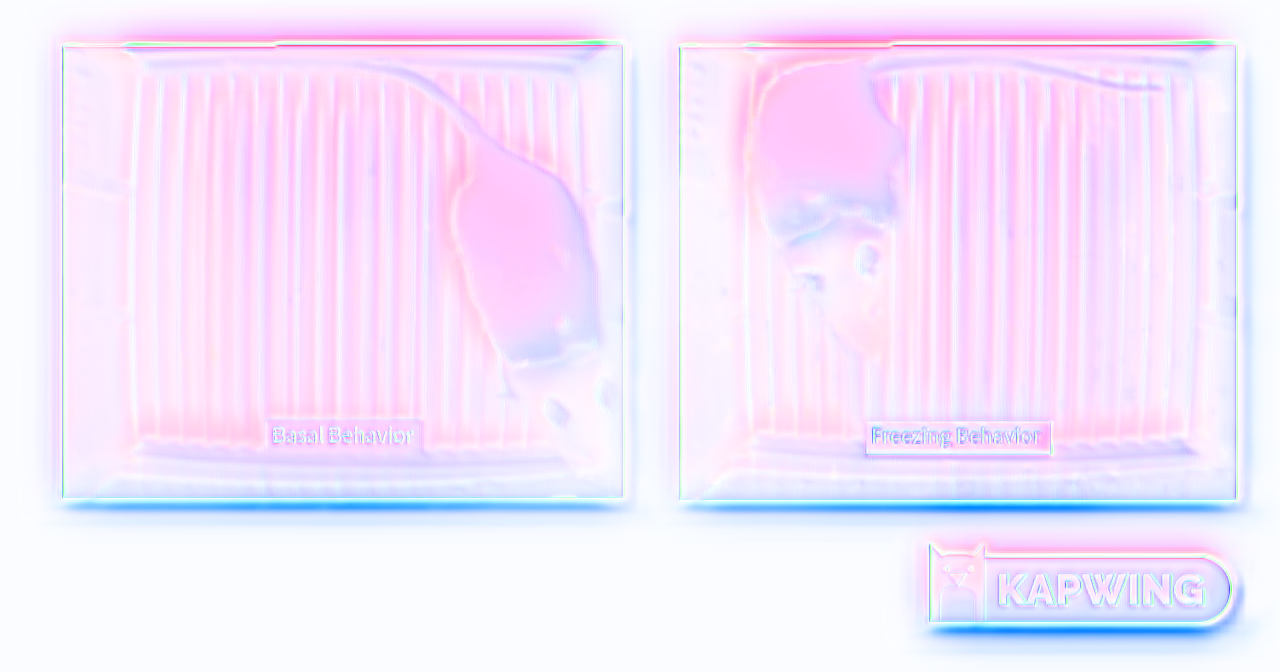

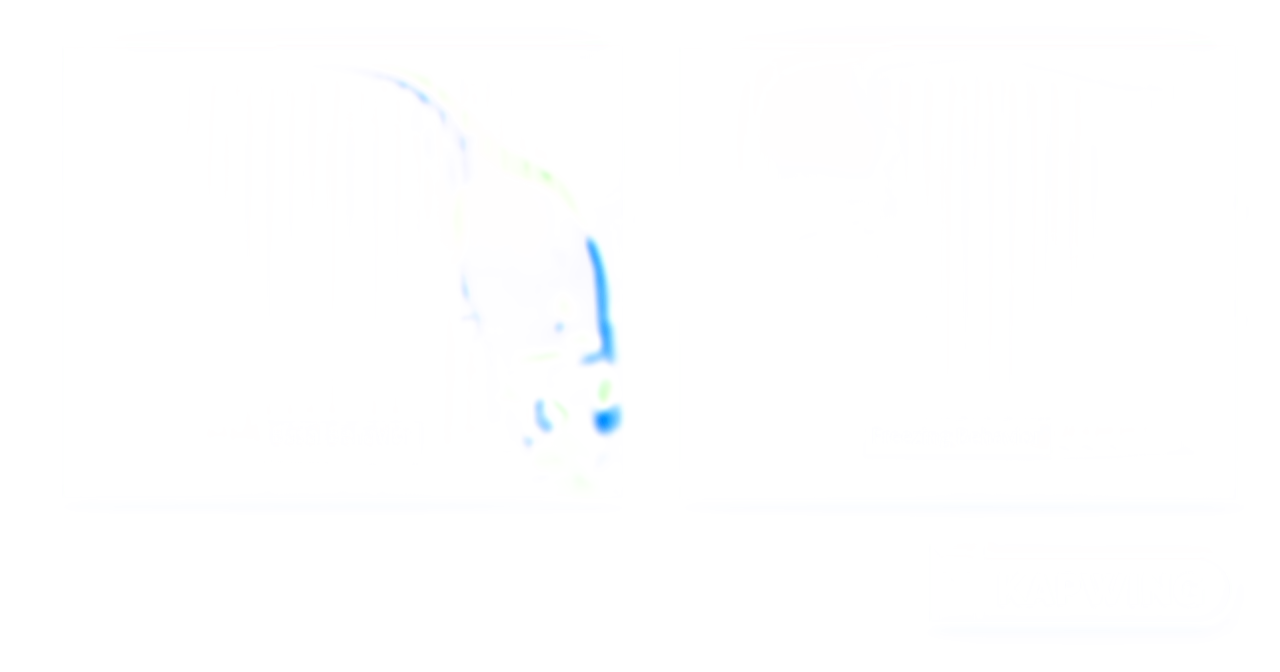

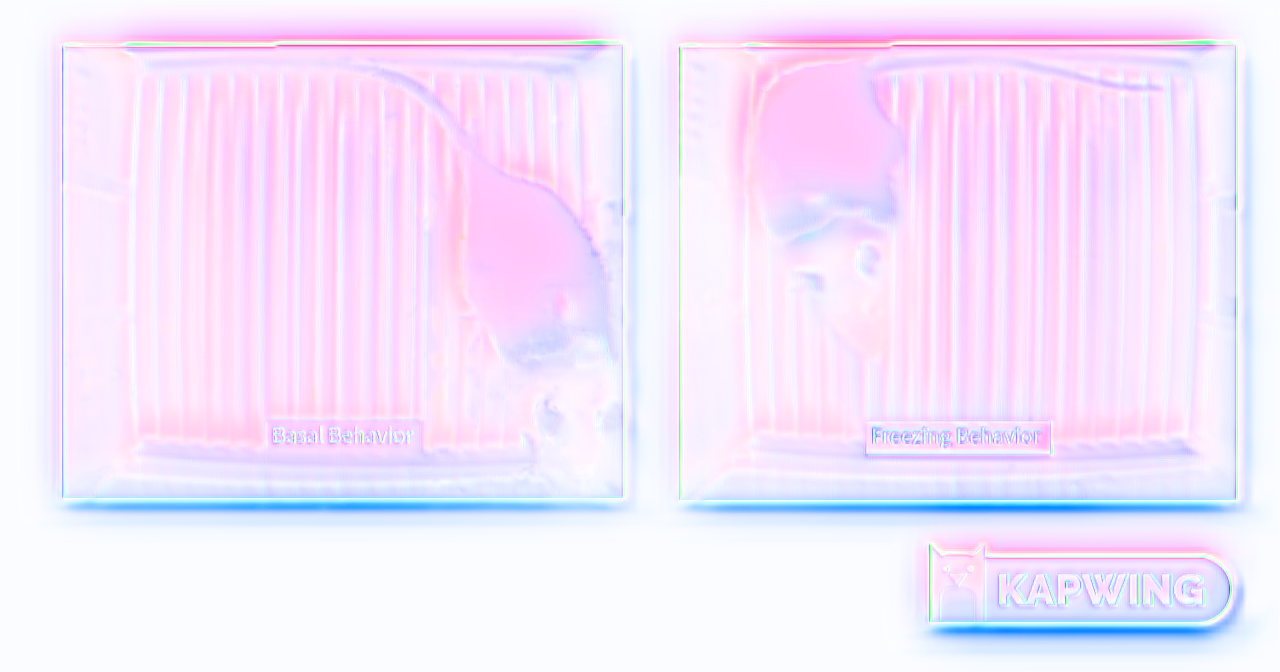

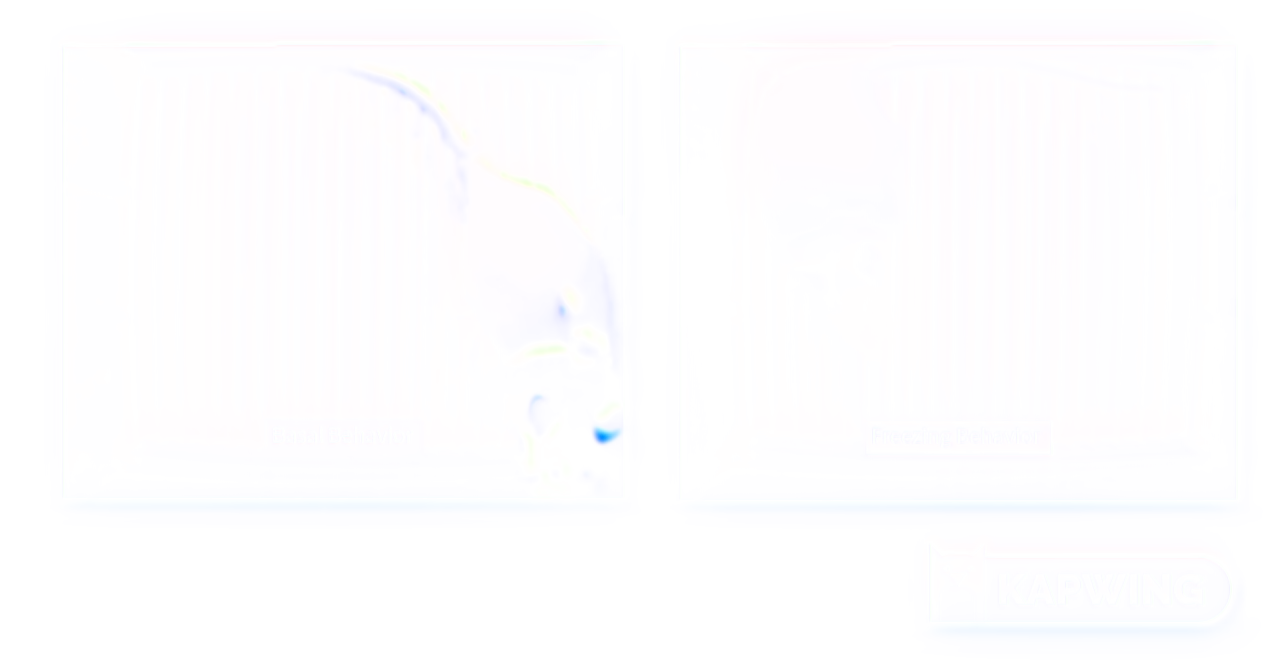

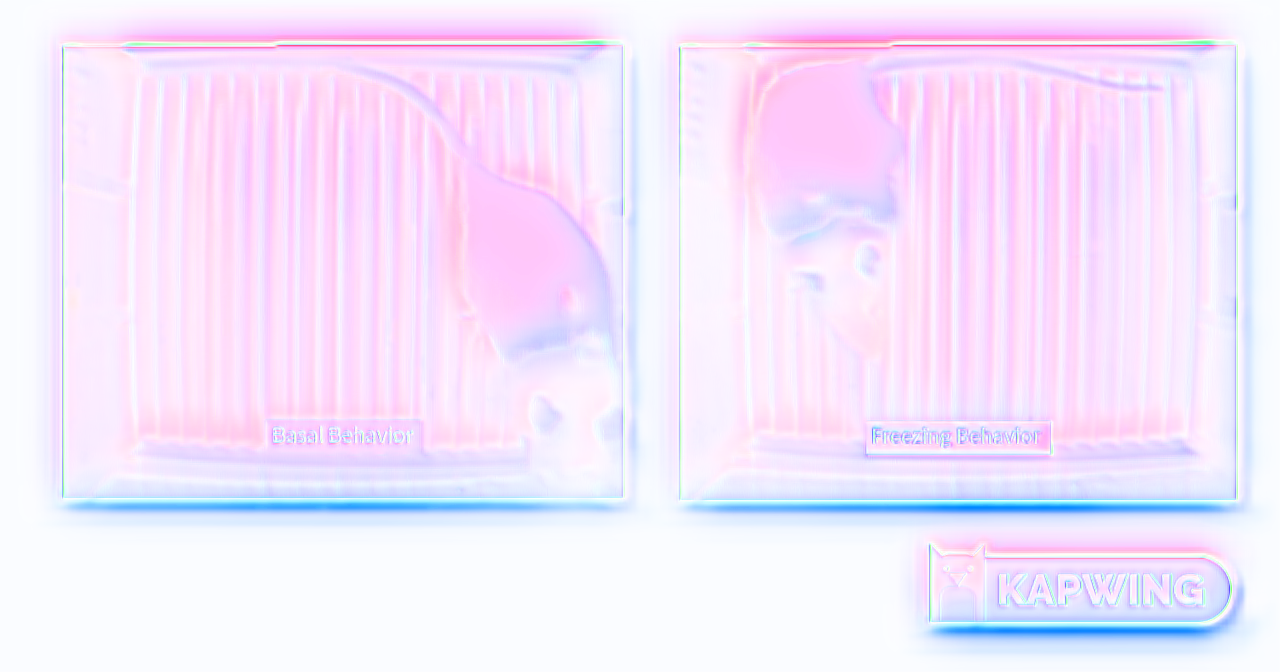

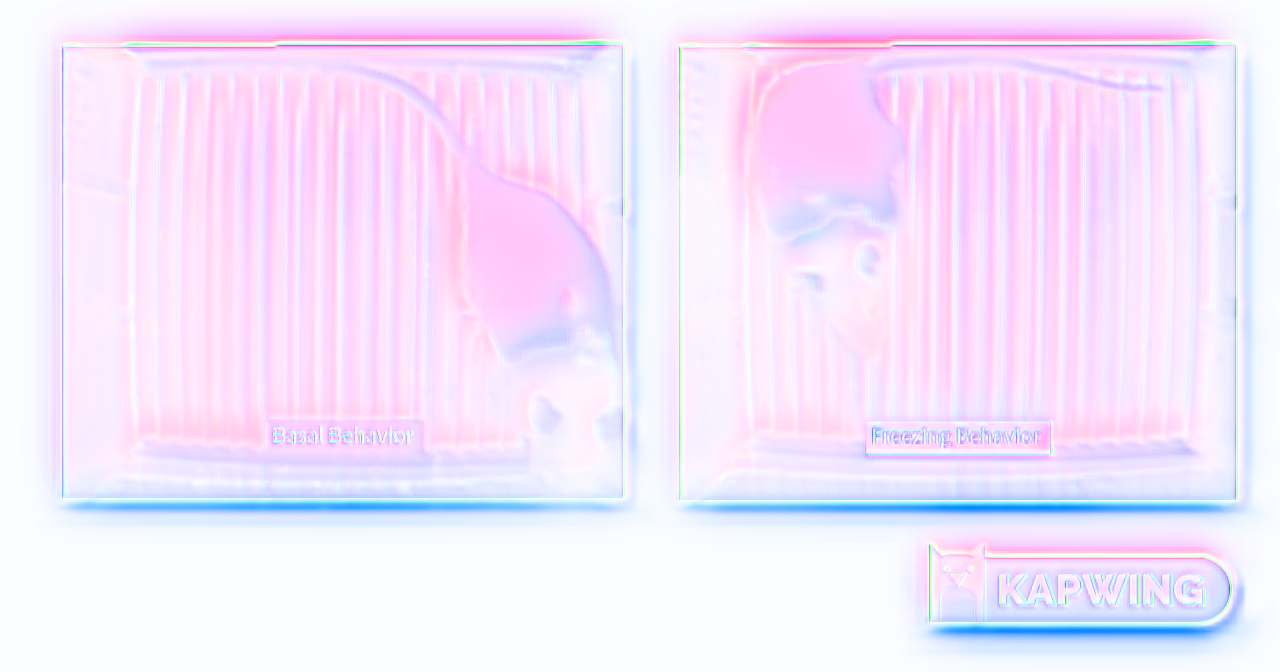

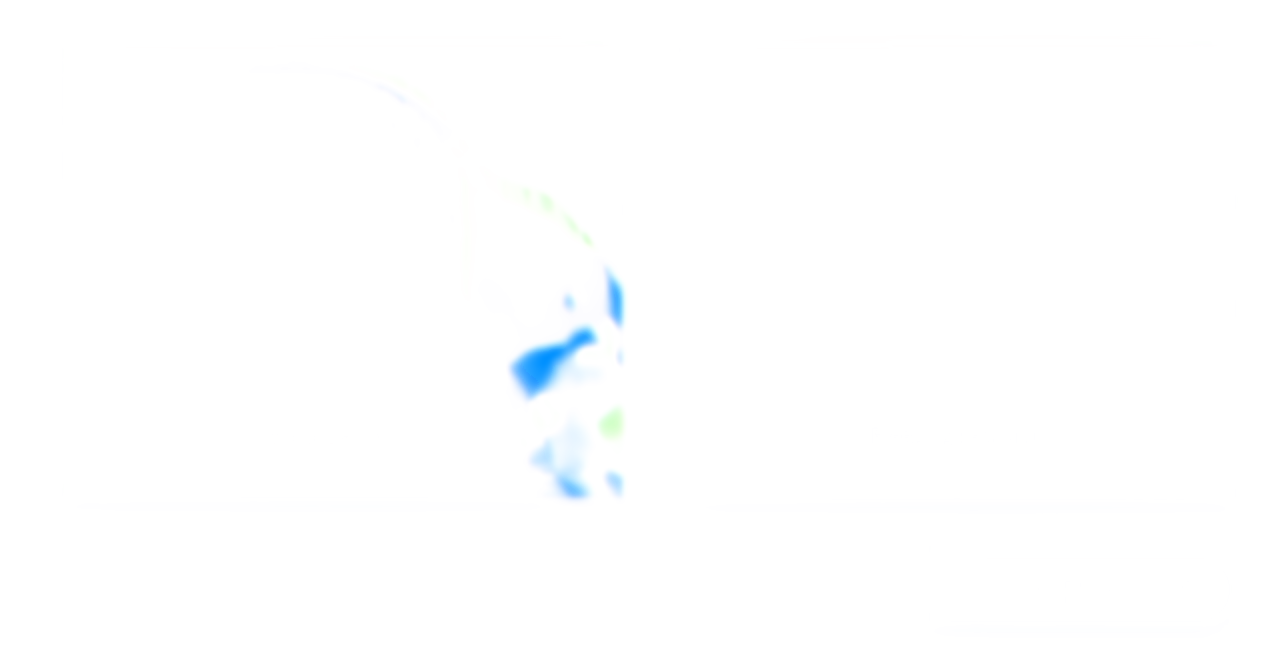

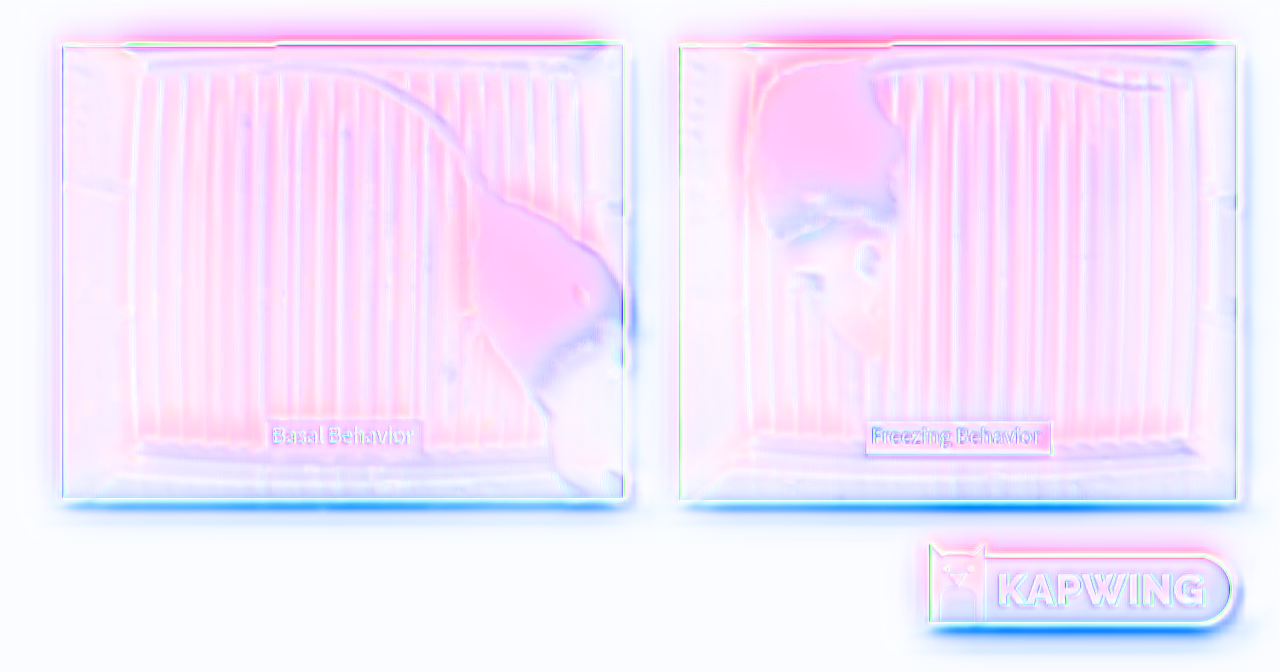

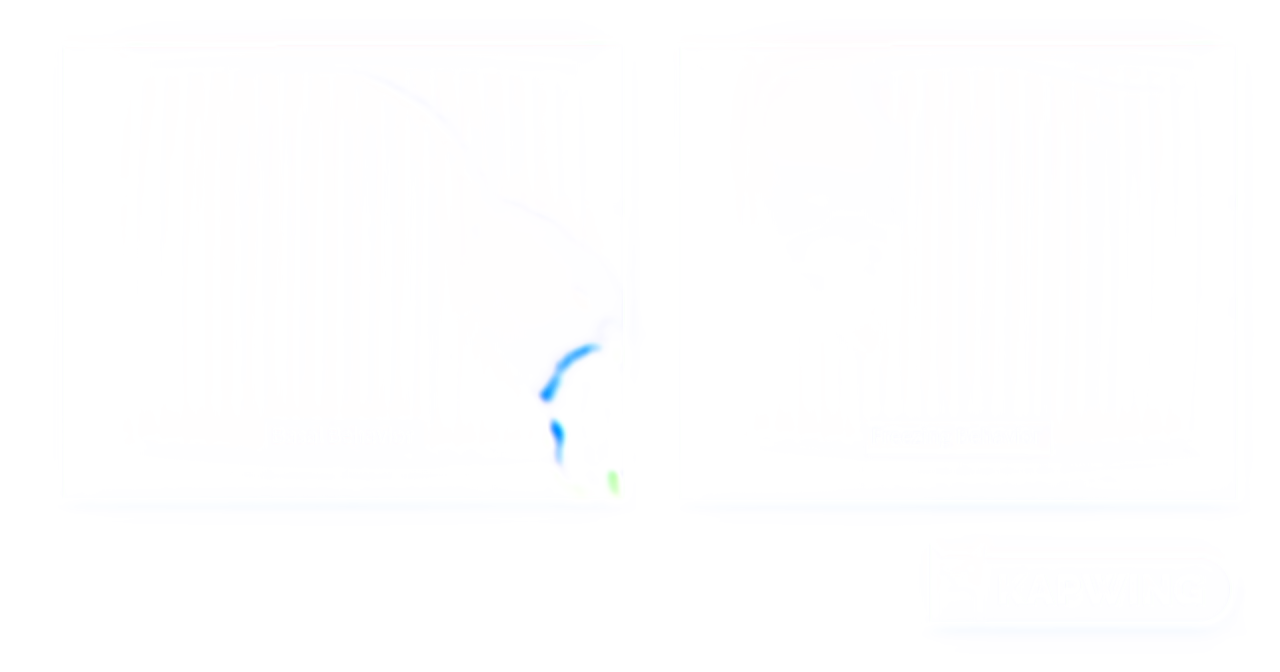

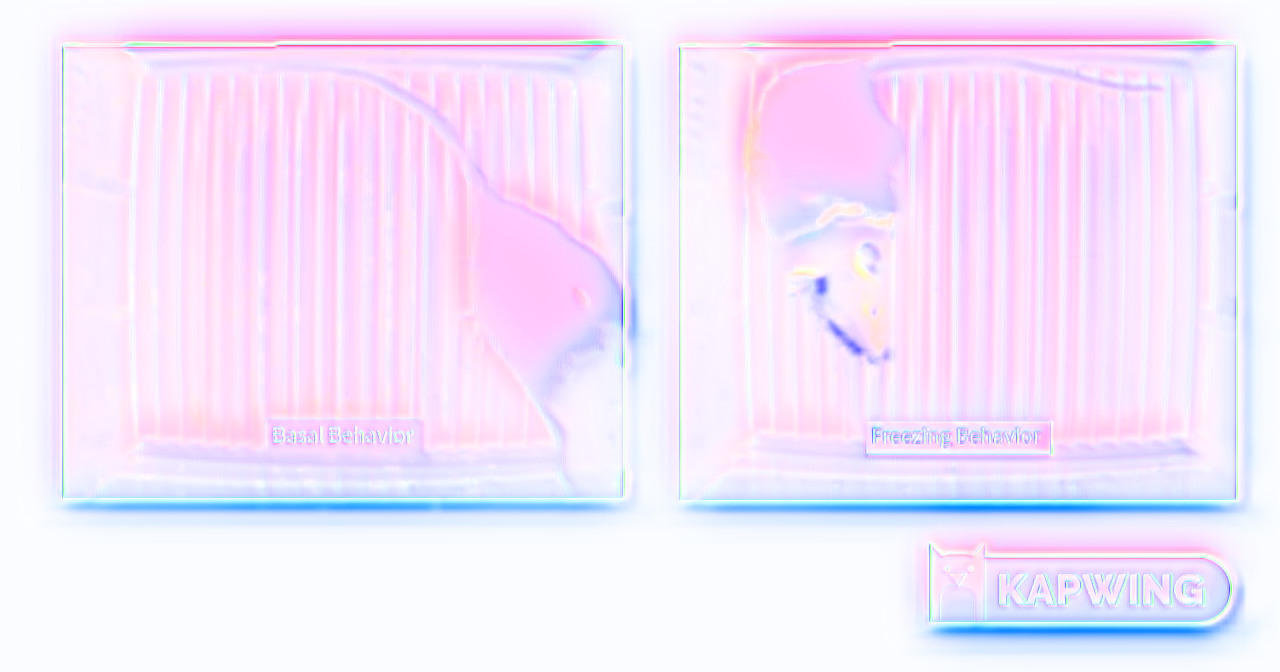

In [56]:
i = 0
for old,new in loader:
    # Generate the moving images and convert them to tensors.
    moving_image, input_fixed  = old.unsqueeze(0), new.unsqueeze(0)
    
    input_moving = moving_image.to(device).float()
  
    input_fixed  = input_fixed.to(device).float()
    
    # Run the data through the model to produce warp and flow field
    warp, flow = fpnet(input_moving, input_fixed)
    _flow_img = flow2hsv(flow.detach().cpu().squeeze().permute(1,2,0).numpy(),show_style=2)
    #_flow_img = draw_flow(moving_image.squeeze(),flow.detach().cpu().squeeze().permute(1,2,0).numpy())
    #_flow = flow.detach().cpu().squeeze().permute(1,2,0).numpy()
    #_flow_img = draw_flow(moving_image.squeeze(),_flow)
    if i >=10:
      break
    i += 1

    cv2_imshow(_flow_img)
    


In [47]:
def warp_flow(img, flow):
    h, w = flow.shape[:2]
    flow = -flow
    flow[:,:,0] += np.arange(w)
    flow[:,:,1] += np.arange(h)[:,np.newaxis]
    res = cv2.remap(img, flow, None, cv2.INTER_LINEAR)
    return res

In [48]:
def video_creator(video_file='output.mp4',
                  fps=30,
                  video_size=vol_shape
                  ):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    creator = cv2.VideoWriter(video_file,
                              fourcc, fps, video_size)
    return creator

current frame:  0


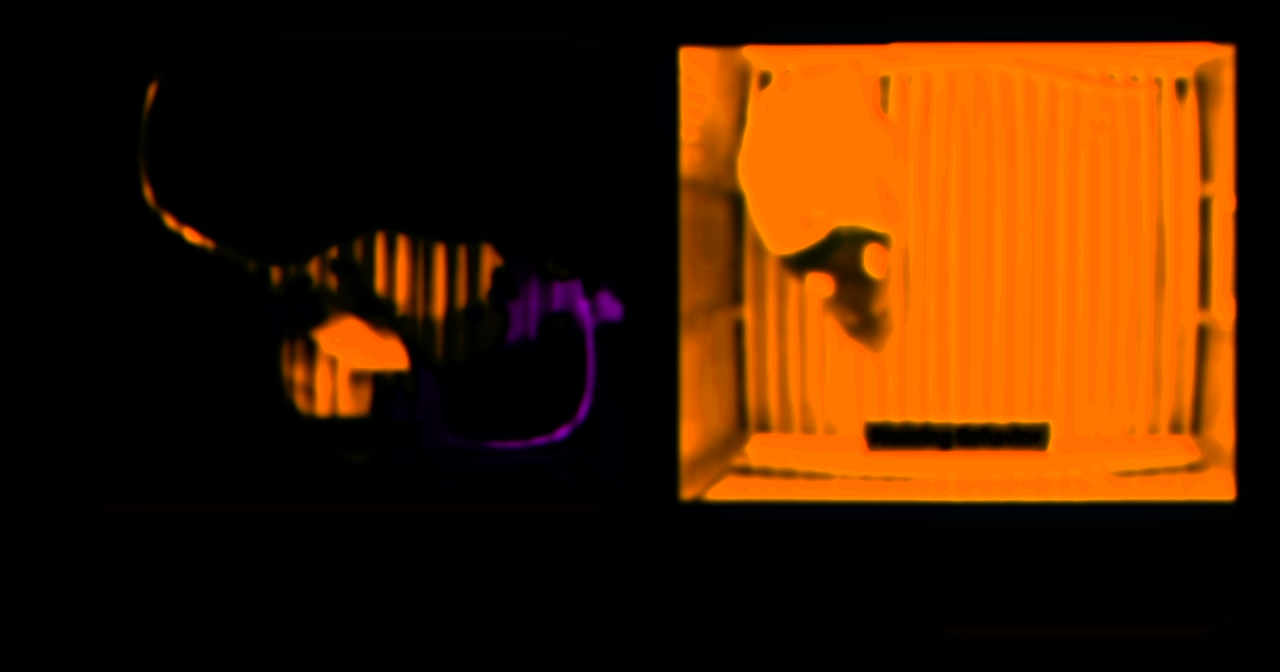

current frame:  40


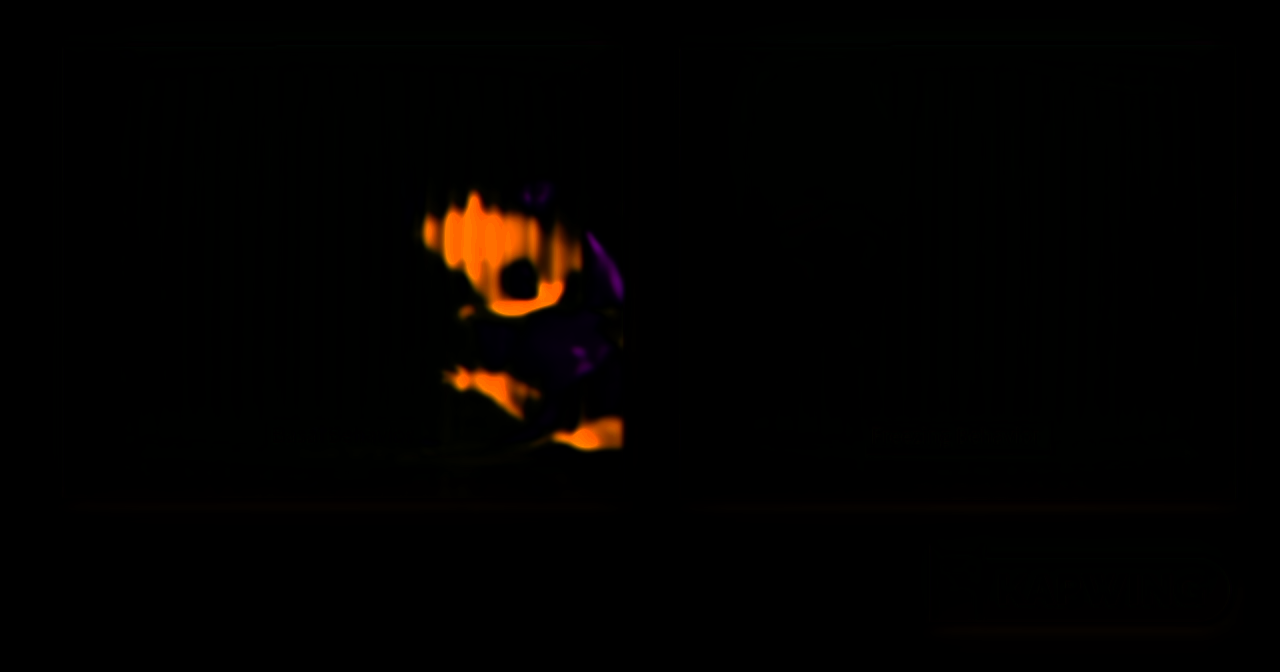

current frame:  80


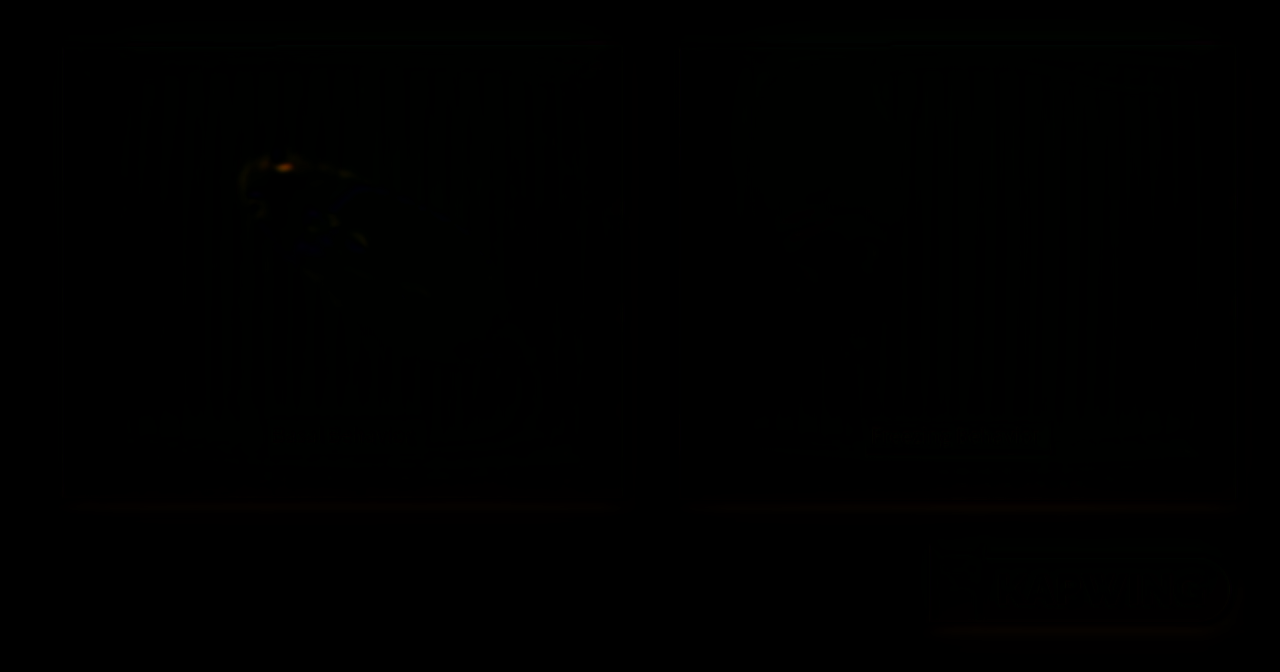

current frame:  120


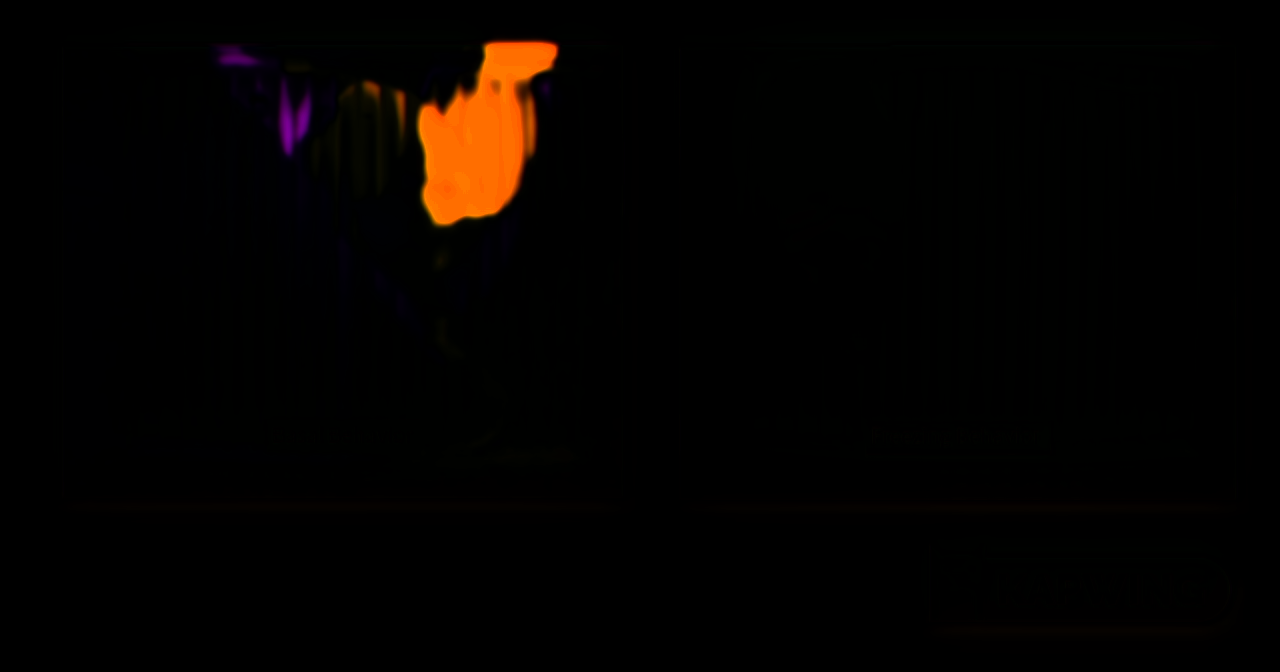

current frame:  160


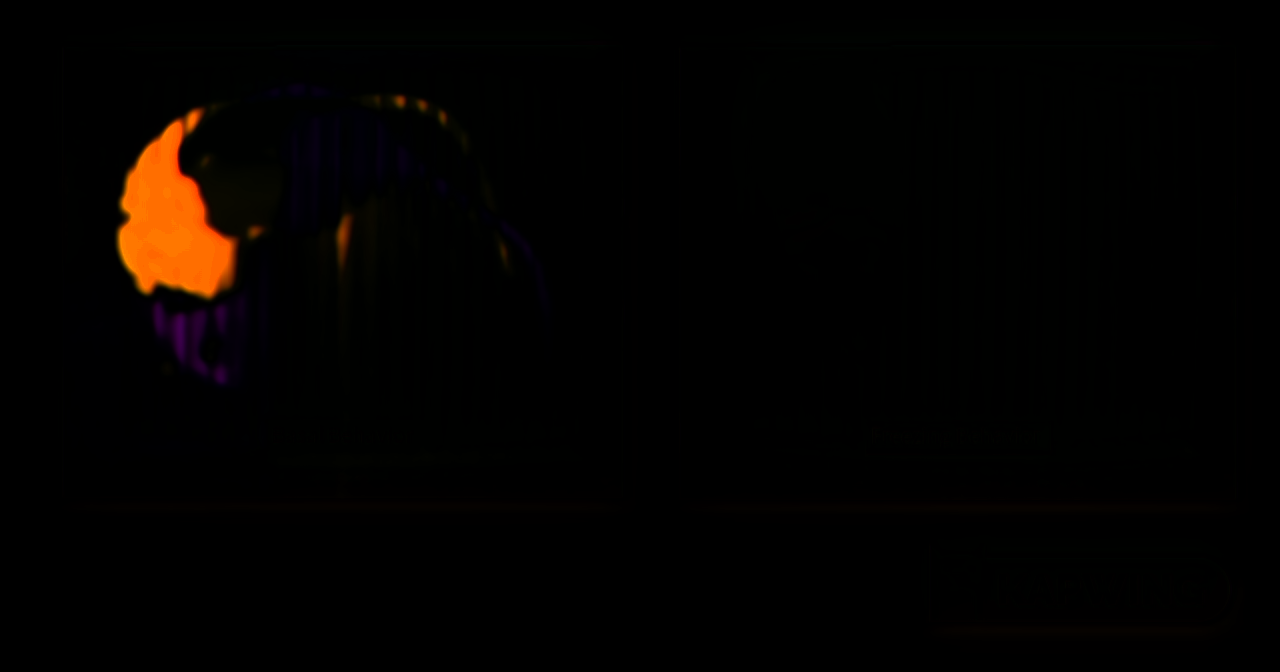

current frame:  200


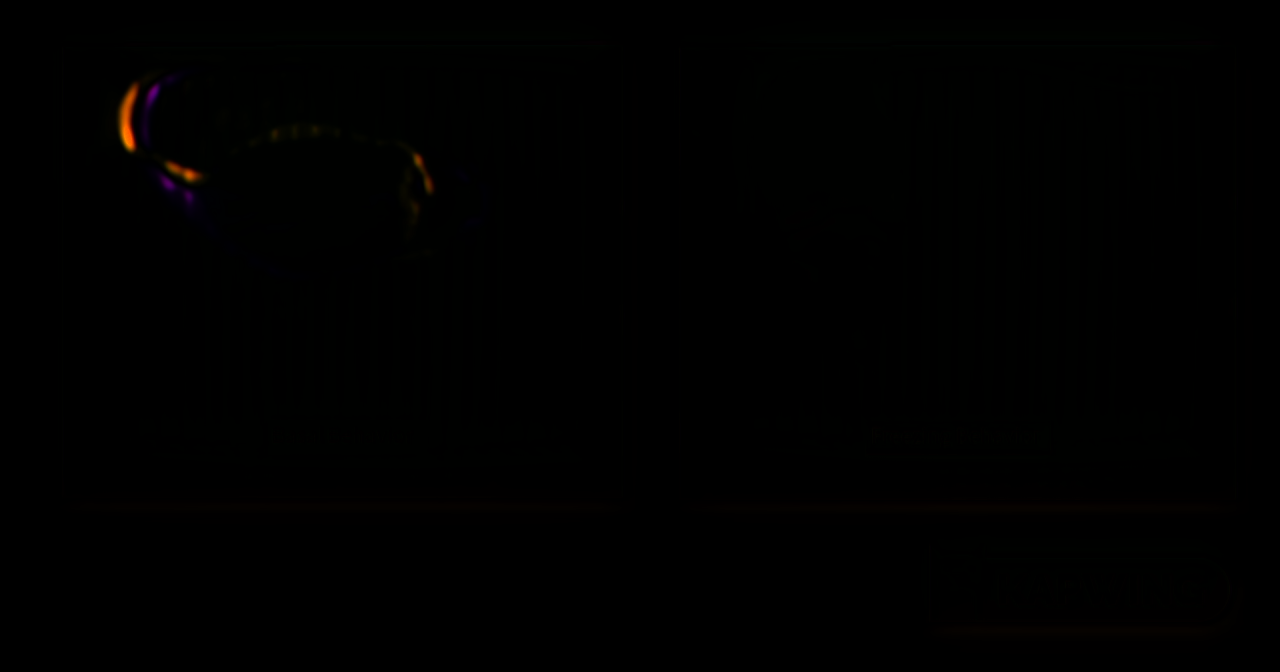

current frame:  240


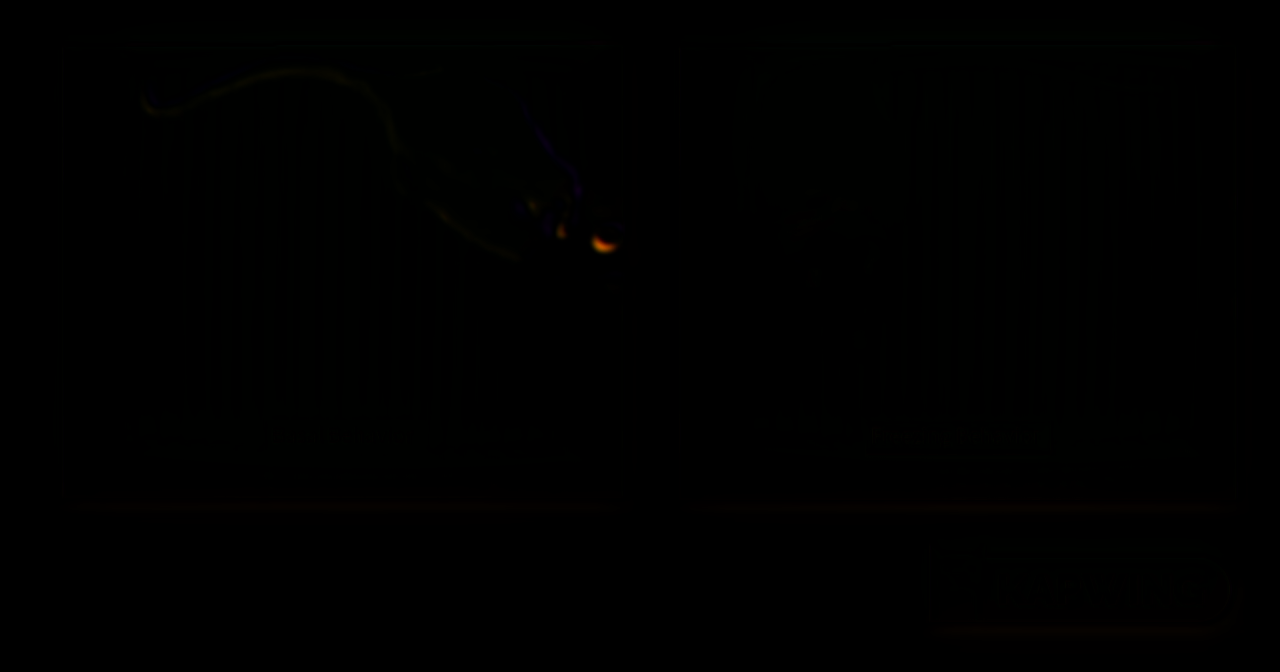

current frame:  280


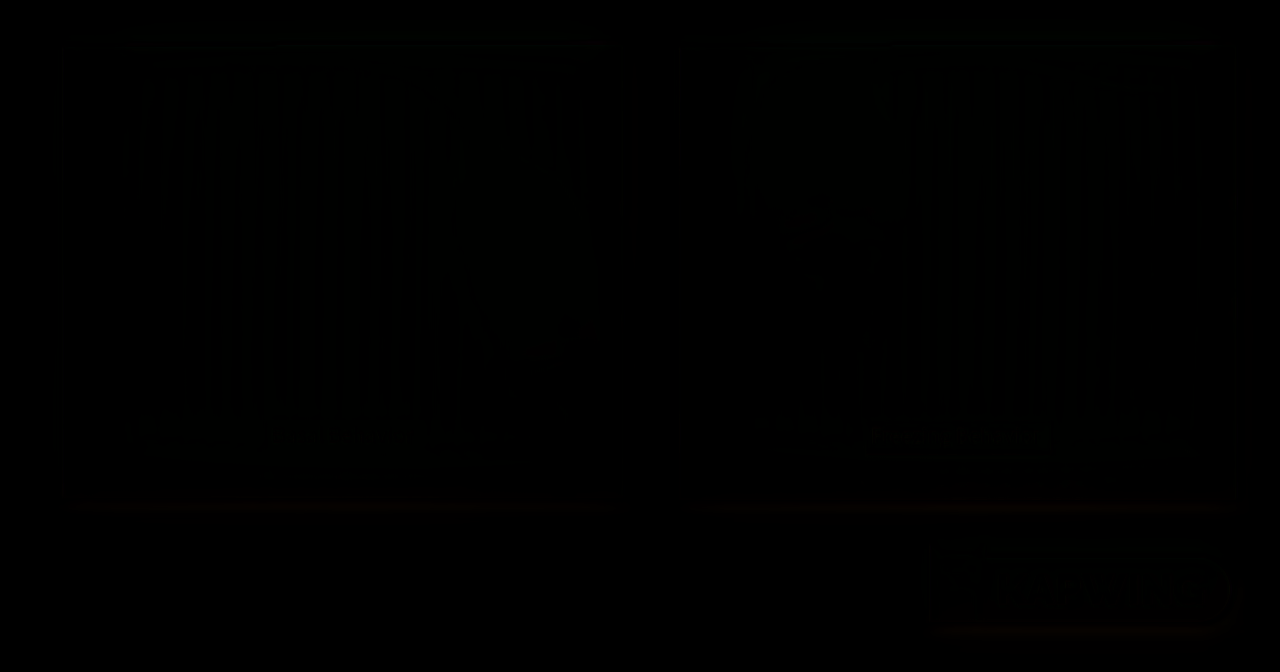

current frame:  320


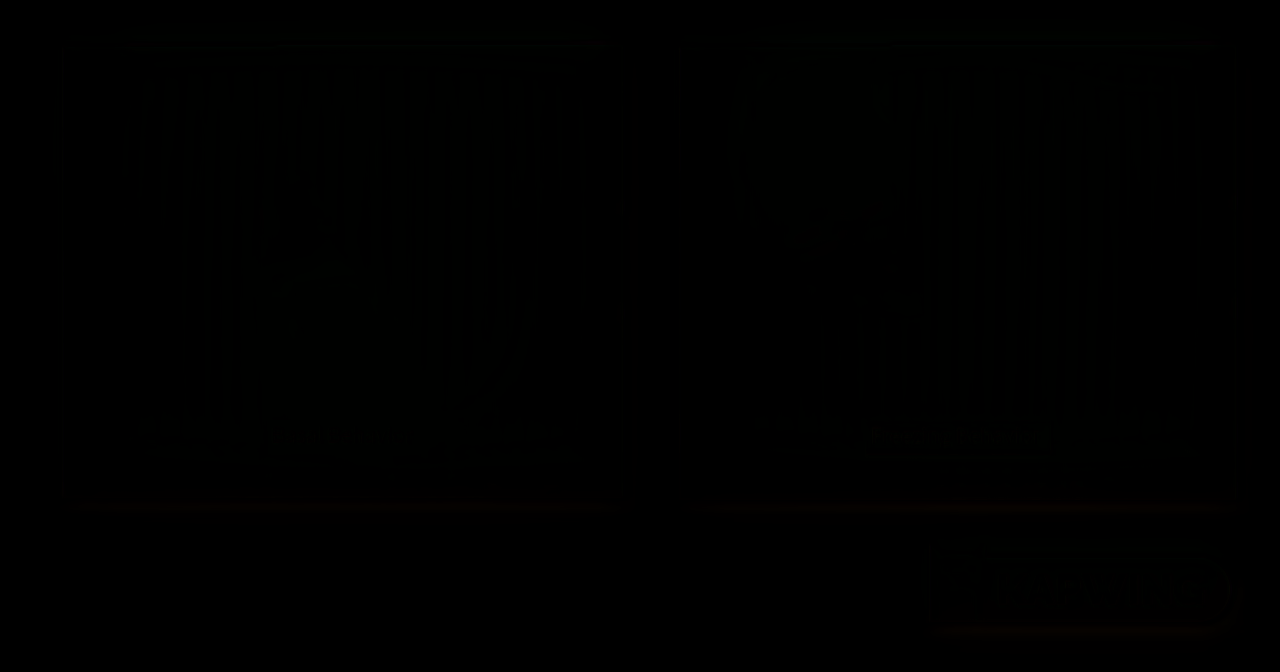

In [53]:
from random import randint
import sys
cam = cv2.VideoCapture(VIDEO_PATH)
ret, prev = cam.read()
if not ret:
    sys.exit(1)
prevgray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)
video_writer = video_creator(video_size=vol_shape)
i_frames = 0
while cam.isOpened():
    ret, img = cam.read()
    if ret:
      gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      moving_image = torch.from_numpy(prevgray).unsqueeze(0).unsqueeze(0)  
      input_fixed = torch.from_numpy(gray).unsqueeze(0).unsqueeze(0)
      input_moving = moving_image.to(device).float()

      input_fixed  = input_fixed.to(device).float()

      # Run the data through the model to produce warp and flow field
      warp, flow = fpnet(input_moving, input_fixed)
      _flow_c = flow.detach().cpu().squeeze().permute(1,2,0).numpy()

      _flow_img = draw_hsv(_flow_c)
      video_writer.write(_flow_img)
      if i_frames % 40 == 0:
          print('current frame: ',i_frames)
          cv2_imshow(_flow_img)
      prevgray = gray
      i_frames += 1
    else:
        break
video_writer.release()      
cv2.destroyAllWindows()
cam.release()

*Reference:* 

[VoxelMorph at TMI](https://arxiv.org/abs/1809.05231)   
[Diffeomorphic VoxelMorph at MedIA](https://arxiv.org/abs/1903.03545)   
[Neurite Library](https://github.com/adalca/neuron) - [CVPR](http://arxiv.org/abs/1903.03148)

https://github.com/voxelmorph/voxelmorph